In [180]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_feasible, init_to_median, init_to_sample, \
    init_to_uniform, init_to_value

In [96]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

In [97]:
N=30 
sigma_obs=0.15
N_test=400
np.random.seed(0)
X = jnp.linspace(-1, 1, N)
Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
Y += sigma_obs * np.random.randn(N)
Y -= jnp.mean(Y)
Y /= jnp.std(Y)

assert X.shape == (N,)
assert Y.shape == (N,)

X_test = jnp.linspace(-1.3, 1.3, N_test)

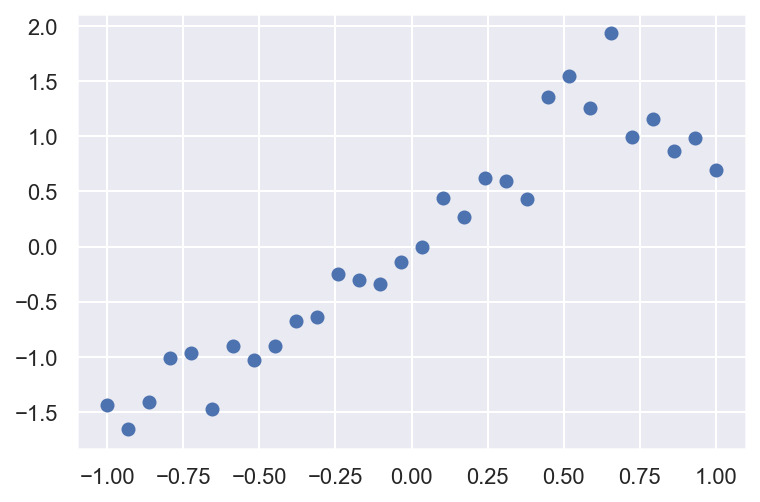

In [98]:
plt.scatter(X, Y);

In [99]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
                   obs=Y)


# helper function for doing hmc inference
def run_inference(rng_key, model, X, Y, init_strategy="median", num_warmup=1000, num_samples=1000, 
                  thinning=2, num_chains=1):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if init_strategy == "value":
        init_strategy = init_to_value(values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5})
    elif init_strategy == "median":
        init_strategy = init_to_median(num_samples=10)
    elif init_strategy == "feasible":
        init_strategy = init_to_feasible()
    elif init_strategy == "sample":
        init_strategy = init_to_sample()
    elif init_strategy == "uniform":
        init_strategy = init_to_uniform(radius=1)
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=num_chains, thinning=thinning,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

In [100]:
# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(rng_key, model, X, Y, num_chains=2)

/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/numpyro/infer/mcmc.py:257: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn('There are not enough devices to run parallel chains: expected {} but got {}.'
  0%|          | 0/2000 [00:00<?, ?it/s]

(30, 30)
(30,)
(30, 30)
(30,)
(30, 30)
(30,)
(30, 30)
(30,)


warmup:   5%|▍         | 91/2000 [00:00<00:02, 905.78it/s, 7 steps of size 1.82e-01. acc. prob=0.78]

(30, 30)
(30,)
(30, 30)
(30,)
(30, 30)
(30,)


sample:  77%|███████▋  | 1541/2000 [00:01<00:00, 943.45it/s, 7 steps of size 4.98e-01. acc. prob=0.94]


KeyboardInterrupt: 

In [12]:
# do prediction
vmap_args = (random.split(rng_key_predict, samples['kernel_var'].shape[0]),
             samples['kernel_var'], samples['kernel_length'], samples['kernel_noise'])
means, predictions = vmap(lambda rng_key, var, length, noise:
                          predict(rng_key, X, Y, X_test, var, length, noise))(*vmap_args)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

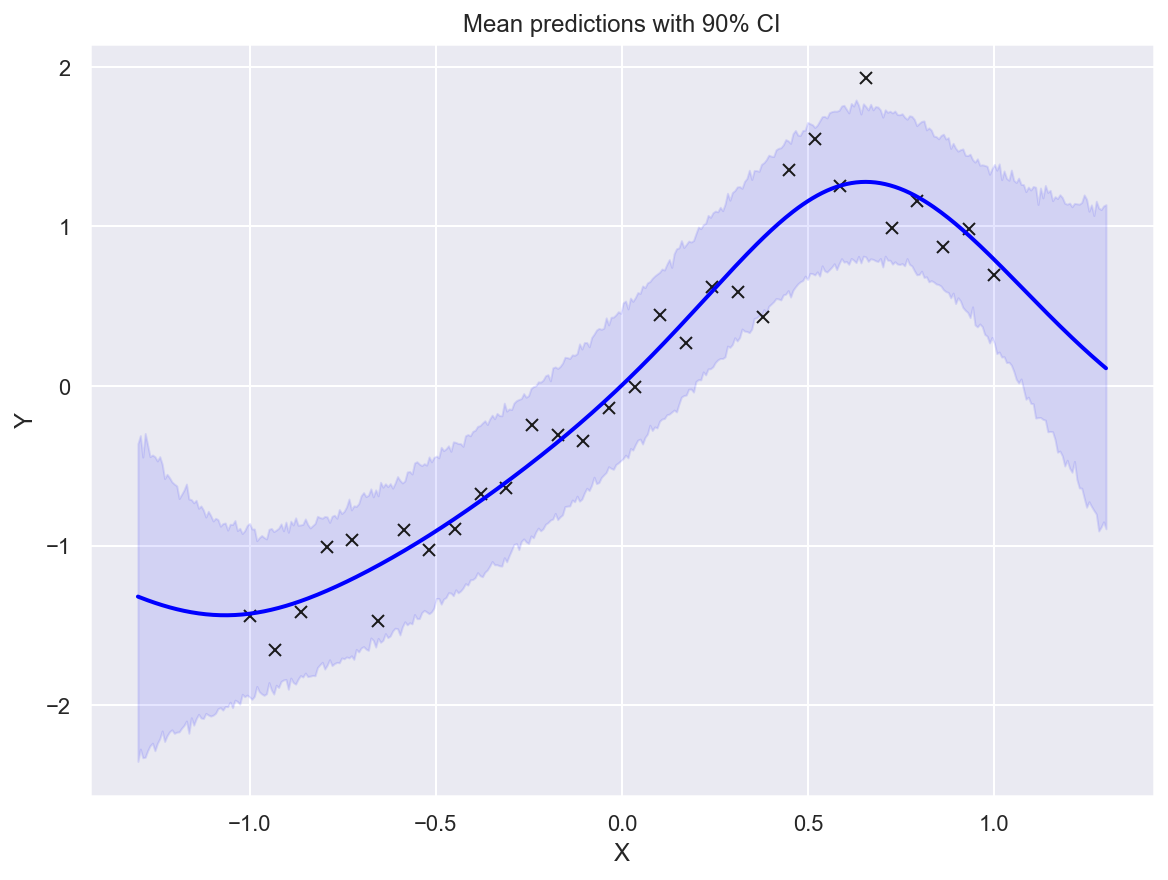

In [13]:
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, 'kx')
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color='blue', alpha=0.1)
# plot mean prediction
ax.plot(X_test, mean_prediction, 'blue', ls='solid', lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");

# Model discrepancy

# Utility models

In [77]:
def u_pow(x, theta): return x**theta[0]

In [78]:
def u_exp(x, theta): return 1 - np.exp(-theta[0]*x)

# Generate choice data

In [79]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=(0.5, )):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

In [80]:
data = generate_data(u=u_pow, n=1000, tau=3.333, theta=(0.5, ))
data

,p0,x0,p1,x1,choices
9002,0.696389,0.007647,0.617248,0.282997,1
7863,0.953285,0.292898,0.380948,0.552913,1
7455,0.060678,0.327938,0.685627,0.158464,1
3414,0.138550,0.276750,0.788651,0.125342,0
5796,0.116159,0.356232,0.732859,0.310642,0
...,...,...,...,...,...
2857,0.928569,0.159319,0.006656,0.571188,0
5417,0.621396,0.103035,0.601608,0.871169,1
1854,0.218694,0.560962,0.389658,0.026879,1
8834,0.980679,0.073375,0.877985,0.777087,1


# Likelihood whole model given M, $\theta_M$

In [81]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1:]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [82]:
def optimize(data, u_m=u_pow, x0=None):
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

In [83]:
optimize(data, u_m=u_pow)

array([3.28496491, 0.53506426])

# Measure discrepancy

In [101]:
u_data = u_pow
theta_data = (0.5, )
tau_data = 3.333
u_model = u_pow
theta_model = (0.5, )
tau_model = 3.333

In [102]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000)

In [184]:
# squared exponential kernel with diagonal noise term
def exp_cov(X, Z, var, length, jitter=1.0e-6):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq) + jitter * jnp.eye(X.shape[0])
    return k

def cov(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * jnp.exp(-0.5 / l**2 * sqdist)


def model(data, u_m, tau, theta):
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values
    
    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))
    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)
    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute M(x)
    X = jnp.array(x_sorted)
    uX = jnp.array(u_m(x_sorted, theta))
    
    # compute kernel
    k = exp_cov(X, X, var, length)
    ck = jax.scipy.linalg.cholesky(k, lower=True)
    
    # sample Y according to the standard gaussian process formula
    # f = numpyro.sample("f", dist.MultivariateNormal(loc=uX, covariance_matrix=k))
    f = numpyro.sample("f", dist.MultivariateNormal(loc=uX, scale_tril=k))
    
    est_eu =  p_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]
    n = len(y)
    diff_eu_hat = est_eu_unsorted[n:] - est_eu_unsorted[:n]

    est_p_choice1 = numpyro.distributions.transforms.expit(tau*diff_eu_hat)
    choose_1 = numpyro.sample("choose_1", dist.Bernoulli(est_p_choice1), obs=y)

In [185]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1, thinning=2)

In [200]:
max_n = 100
if len(data) > max_n:
    np.random.seed(12345)
    data_gp = data.sample(n=max_n, replace=False)
else:
    data_gp = data

mcmc.run(random.PRNGKey(0), data=data_gp, theta=theta_model, tau=tau_model, u_m=u_model)

sample: 100%|██████████| 2000/2000 [00:24<00:00, 81.85it/s, 15 steps of size 4.99e-02. acc. prob=0.63] 


In [201]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           f[0]      0.09      0.05      0.09      0.03      0.17    339.40      1.00
           f[1]      0.09      0.04      0.09      0.01      0.15    507.55      1.00
           f[2]      0.14      0.05      0.14      0.04      0.20    395.66      1.00
           f[3]      0.13      0.06      0.13      0.01      0.22    391.45      1.00
           f[4]      0.15      0.05      0.15      0.08      0.23    502.60      1.00
           f[5]      0.15      0.05      0.15      0.08      0.24    416.32      1.00
           f[6]      0.16      0.05      0.16      0.09      0.23    440.73      1.00
           f[7]      0.15      0.05      0.16      0.06      0.22    166.21      1.02
           f[8]      0.18      0.04      0.18      0.12      0.25    412.55      1.00
           f[9]      0.18      0.05      0.19      0.11      0.25    517.77      1.00
          f[10]      0.18      0.05      0.19      0.

In [197]:
samples = np.asarray(mcmc.get_samples()['f'])

In [198]:
import pymc3 as pm

<AxesSubplot:>

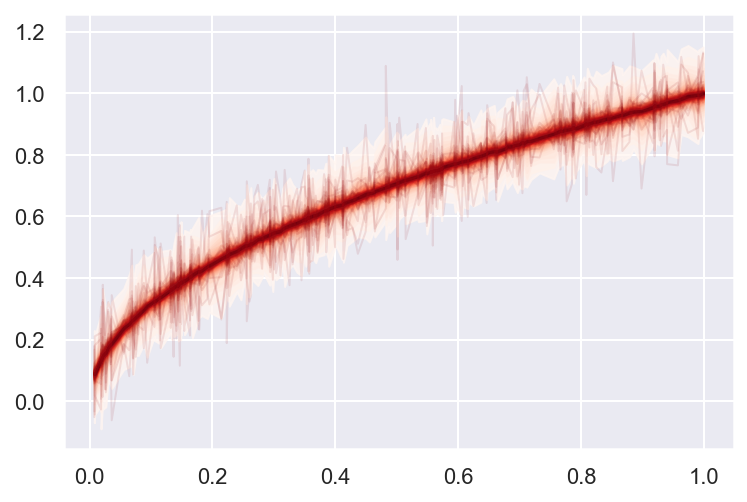

In [199]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, samples, x_sorted.reshape(-1, 1))